In [1]:
import matplotlib.pyplot as plt
import pandas
import numpy as np

# gerrychain imports
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election)
from gerrychain.proposals import recom
from gerrychain.tree import recursive_tree_part
from gerrychain.accept import always_accept
from gerrychain.constraints import (Validator, single_flip_contiguous,
                                    within_percent_of_ideal_population, UpperBound)
from functools import partial

In [2]:
# State specific variables
state = "LA" # Louisiana
num_districts = 39 # senate districts
data_path = "./LA_data/LA_data.json"
pop_varname = "TOTPOP"
bvap_varname = "BVAP"
vap_varname = "VAP"
num_markov_steps = 10 # in Markov chain
OPPORTUNITY_PERCENT = 0.4

In [3]:
# load the graph
graph = Graph.from_json(data_path)

In [4]:
#################################################################################
########################## Get ideal population  ################################
#################################################################################

def get_ideal_population(graph, pop_varname, num_districts):
    tot_pop = 0
    for i in range(len(graph.nodes)):
        tot_pop += graph.nodes[i][pop_varname]
        
    return int(tot_pop/num_districts)

ideal_population = get_ideal_population(graph, pop_varname, num_districts)

####################################################################################
############################# Define the updaters ##################################
####################################################################################

def count_opportunity_districts(partition):
    opp_percent = OPPORTUNITY_PERCENT
    
    num_opp_dists = 0
    for i in range(num_districts):
        num_bvap_percent = partition["bvap"][i] / partition["vap"][i]
        
        if num_bvap_percent >= opp_percent:
            num_opp_dists += 1

    return num_opp_dists

def compute_funky_score(partition):
    curr_bvap_list = []
    
    for i in range(num_districts):
        curr_bvap_percent = partition["bvap"][i] / partition["vap"][i]
        curr_bvap_list.append(curr_bvap_percent)
    
    curr_bvap_list = sorted(curr_bvap_list)
    
    curr_funky_score = 0
    for i in range(num_districts-1,-1,-1):
        if curr_bvap_list[i] >= OPPORTUNITY_PERCENT:
            curr_funky_score += 1
        else:
            curr_funky_score += curr_bvap_list[i]
            break
    
    return curr_funky_score

####################################################################################
###################### End of updater definitions ##################################
####################################################################################

updaters = {"population": updaters.Tally(pop_varname, alias="population"),
            "bvap":updaters.Tally(bvap_varname, alias='bvap'),
            "vap":updaters.Tally(vap_varname, alias='vap'),
            "opportunity_districts":count_opportunity_districts,
            "funky_score": compute_funky_score
           }

In [5]:
####################################################################################
################ Build Initial Partition and Markov Chain ##########################
####################################################################################

# assign each node to a district in a dict of the form {node: district}
seed_partition_dict = recursive_tree_part(graph, 
                                          range(39), 
                                          pop_col=pop_varname,
                                          pop_target=ideal_population,
                                          epsilon=0.01, 
                                          node_repeats=1)

# use the partition dictionary to build a Partition object
seed_partition = GeographicPartition(graph, 
                                     assignment=seed_partition_dict, 
                                     updaters=updaters)

## Build the Markov chain
tree_proposal = partial(recom,
                        pop_col=pop_varname,
                        pop_target=ideal_population,
                        epsilon=0.05,
                        node_repeats=1)

# Constraints
popbound = within_percent_of_ideal_population(seed_partition, .1)

####################################################################################
###################### Define the acceptance functions #############################
####################################################################################

def increase_opportunity_districts(partition):
    opp_percent = OPPORTUNITY_PERCENT
    if partition.parent is None:
        return True
    
    curr_opp_dists = 0
    prev_opp_dists = 0
    for i in range(num_districts):
        curr_bvap_percent = partition["bvap"][i] / partition["vap"][i]
        prev_bvap_percent = partition.parent["bvap"][i] / partition.parent["vap"][i]
        
        if curr_bvap_percent >= opp_percent:
            curr_opp_dists += 1
        if prev_bvap_percent >= opp_percent:
            prev_opp_dists += 1

    return curr_opp_dists >= prev_opp_dists

# Funky Weighted Opportunity Score
def increase_funky_opportunity_score(partition):
    
    curr_bvap_list = []
    prev_bvap_list = []
    
    for i in range(num_districts):
        curr_bvap_percent = partition["bvap"][i] / partition["vap"][i]
        prev_bvap_percent = partition.parent["bvap"][i] / partition.parent["vap"][i]
        
        curr_bvap_list.append(curr_bvap_percent)
        prev_bvap_list.append(prev_bvap_percent)
    
    curr_bvap_list = sorted(curr_bvap_list)
    prev_bvap_list = sorted(prev_bvap_list)
    
    curr_bvap_score = 0
    for i in range(num_districts-1,-1,-1):
        if curr_bvap_list[i] >= OPPORTUNITY_PERCENT:
            curr_bvap_score += 1
        else:
            curr_bvap_score += curr_bvap_list[i]
            break
    
    prev_bvap_score = 0 
    for i in range(num_districts-1,-1,-1):
        if prev_bvap_list[i] >= OPPORTUNITY_PERCENT:
            prev_bvap_score += 1
        else:
            prev_bvap_score += prev_bvap_list[i]
            break
    
    return curr_bvap_score >= prev_bvap_score        

In [17]:
####################################################################################
################################## Short Burst #####################################
####################################################################################    

def short_burst_run(initial_partition, num_bursts, num_steps, accept_function):
    max_partition = initial_partition
    max_score = 0 # bhushan come back here later...
    
    score_list = []

    for i in range(num_bursts):
        
        chain = MarkovChain(tree_proposal, 
                          Validator([popbound]), 
                          accept=accept_function,
                          initial_state=max_partition, 
                          total_steps=num_steps)

        for partition in chain:
            current_score = count_opportunity_districts(partition)
            
            if current_score >= max_score:
                max_partition = partition
                max_score = current_score
                # > or >= has implications, not sure which is best...
            
            score_list.append(current_score)
                

    return score_list


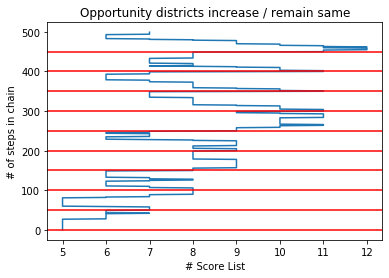

In [29]:
score_list = short_burst_run(seed_partition,10,50,always_accept)

ticks = range(0, 500, 50)
plt.plot(score_list, range(500))
plt.title("Opportunity districts increase / remain same")
plt.xlabel("# Score List")
plt.ylabel("# of steps in chain")
for tick in ticks:
    plt.axhline(y=tick, color='r')

plt.show()

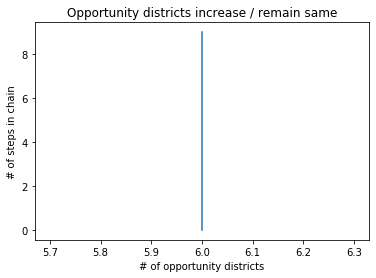

In [8]:
# Opportunity district cell
recom_chain = MarkovChain(tree_proposal, 
                          Validator([popbound]), 
                          accept=increase_opportunity_districts,
                          initial_state=seed_partition, 
                          total_steps=num_markov_steps)

opportunity_districts_counts = []

for partition in recom_chain:
    opportunity_districts_counts.append(partition["opportunity_districts"])
    
plt.plot(opportunity_districts_counts, range(num_markov_steps))
plt.title("Opportunity districts increase / remain same")
plt.xlabel("# of opportunity districts")
plt.ylabel("# of steps in chain")

# save array 
opportunity_districts_counts = np.array(opportunity_districts_counts)
np.save("opportunity_district_counts", opportunity_districts_counts)

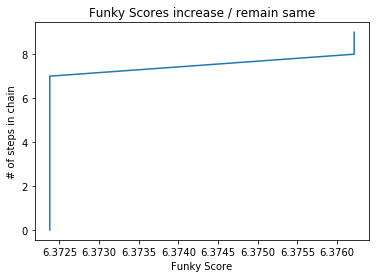

In [9]:
# Funky score cell

recom_chain = MarkovChain(tree_proposal, 
                          Validator([popbound]), 
                          accept=increase_funky_opportunity_score,
                          initial_state=seed_partition, 
                          total_steps=num_markov_steps)

funky_scores = []

for partition in recom_chain:    
    funky_scores.append(partition["funky_score"])      

plt.plot(funky_scores, range(num_markov_steps))
plt.title("Funky Scores increase / remain same")
plt.xlabel("Funky Score")
plt.ylabel("# of steps in chain")

# save array 
funky_scores = np.array(funky_scores)
np.save("funky_scores", funky_scores)